This notebook was developed using qBraid and Qiskit to demonstrate
foundational and applied quantum computing skills, including:

- Bell state generation (ideal and noisy)
- Grover's algorithm (2-qubit)
- Deutsch–Jozsa algorithm (n=3)
- Superconducting qubit noise simulations (T1, T2, depolarizing)
- Open Quantum Systems Simulation (QuTiP, Lindblad, driven transmon)
- DRAG Pulse Design in Qiskit Pulse (|1⟩→|2⟩ leakage suppression)

# Environment Check (qBraid / JupyterLab)

This cell verifies that **Qiskit**, **Aer**, and **QuTiP** are available in your current kernel.  
If QuTiP is missing in qBraid's *Python 3 (Qiskit)* kernel, try **one** of the install commands below **in a new cell**, then **restart the kernel**:

**Option A — pip (often works on qBraid):**
```python
%pip install --user qutip
```

**Option B — conda/mamba (if available in terminal or a notebook shell):**
```bash
mamba install -c conda-forge qutip -y
# or
conda install -c conda-forge qutip -y
```

After install: *Kernel → Restart Kernel*, then run this notebook again.

In [1]:
import sys, importlib, platform

def check_import(modname):
    try:
        m = importlib.import_module(modname)
        return True, getattr(m, '__version__', 'unknown')
    except Exception as e:
        return False, repr(e)

print("Python:", sys.version.split()[0], "| Executable:", sys.executable)
print("Platform:", platform.platform())

ok_qiskit, ver_qiskit = check_import('qiskit')
ok_aer, ver_aer = check_import('qiskit_aer')
ok_qutip, ver_qutip = check_import('qutip')

print(f"Qiskit: {'OK' if ok_qiskit else 'MISSING'} | version: {ver_qiskit}")
print(f"Aer:    {'OK' if ok_aer else 'MISSING'} | version: {ver_aer}")
print(f"QuTiP:  {'OK' if ok_qutip else 'MISSING'} | version: {ver_qutip}")

if not ok_qutip:
    print("""\nQuTiP is missing in this kernel.
Install it and restart the kernel, e.g.:
  %pip install --user qutip
Then re-run this notebook.
""")

Python: 3.11.9 | Executable: /opt/.qbraid/environments/qbraid_000000/pyenv/bin/python
Platform: Linux-6.6.97+-x86_64-with-glibc2.35
Qiskit: OK | version: 2.0.2
Aer:    OK | version: 0.17.1
QuTiP:  OK | version: 5.2.1


In [2]:
# Qiskit Aer environment setup (qBraid reproducibility)
!pip uninstall -y qiskit-aer qiskit qiskit-terra
!pip cache purge
!pip install qiskit==2.0.2
!pip install qiskit-aer[cpu]
!pip list | grep qiskit

Found existing installation: qiskit-aer 0.17.1
Uninstalling qiskit-aer-0.17.1:
  Successfully uninstalled qiskit-aer-0.17.1
Found existing installation: qiskit 2.0.2
Uninstalling qiskit-2.0.2:
  Successfully uninstalled qiskit-2.0.2
Files removed: 12 (19.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 74.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 105.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
qiskit                       2.0.2
qiskit-aer                   0.17.1
qiskit-ibm-provider          0.11.0


## 1. Bell State with Measurement Sampling

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

backend = Aer.get_backend('qasm_simulator')
result = backend.run(transpile(qc, backend), shots=4096).result()
print('Bell counts:', result.get_counts())

Bell counts: {'00': 2065, '11': 2031}


## 2. Ideal Statevector Simulation

In [4]:
import numpy as np

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

sv_backend = Aer.get_backend('statevector_simulator')
sv = np.array(sv_backend.run(qc).result().get_statevector(), dtype=complex)
print('Statevector:', sv)
print('Probability sum:', float((np.abs(sv) ** 2).sum()))

Statevector: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Probability sum: 1.0


## 3. Noisy Bell State Simulation (Depolarizing Errors)

In [5]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()

result_noisy = backend.run(transpile(qc, backend), shots=8192, noise_model=noise_model).result()
print('Noisy counts:', result_noisy.get_counts())

Noisy counts: {'01': 35, '10': 51, '00': 3996, '11': 4110}


## 4. Grover's Algorithm (2-qubit demo)

In [6]:
def grover_oracle_11(n=2):
    qc = QuantumCircuit(n)
    qc.cz(0, 1)
    return qc

def diffuser(n=2):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.cx(0, 1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

grover_it = QuantumCircuit(2, 2)
grover_it.h(range(2))
grover_it.append(grover_oracle_11(2), range(2))
grover_it.append(diffuser(2), range(2))
grover_it.measure(range(2), range(2))

res_ideal = backend.run(transpile(grover_it, backend), shots=4096).result()
print('Grover ideal counts:', res_ideal.get_counts())

Grover ideal counts: {'11': 4096}


## 5. Deutsch–Jozsa Algorithm (n=3)

In [7]:
def dj_constant_oracle(n=3, flips_output=False):
    qc = QuantumCircuit(n+1)
    if flips_output:
        qc.x(n)
    return qc

def dj_balanced_oracle(n=3):
    qc = QuantumCircuit(n+1)
    qc.cx(0, n)
    qc.cx(1, n)
    return qc

def deutsch_jozsa_run(oracle, n=3):
    qc = QuantumCircuit(n+1, n)
    qc.x(n)
    qc.h(range(n+1))
    qc.append(oracle, range(n+1))
    qc.h(range(n))
    qc.measure(range(n), range(n))
    return qc

oracle_c0 = dj_constant_oracle(3, flips_output=False).to_gate()
qc_c0 = deutsch_jozsa_run(oracle_c0, 3)
res_c0 = backend.run(transpile(qc_c0, backend), shots=2048).result()
print('DJ constant-0:', res_c0.get_counts())

DJ constant-0: {'000': 2048}


## 6. Superconducting Qubit Noise Simulation (T1, T2, depolarizing)

{'0': 504, '1': 496}


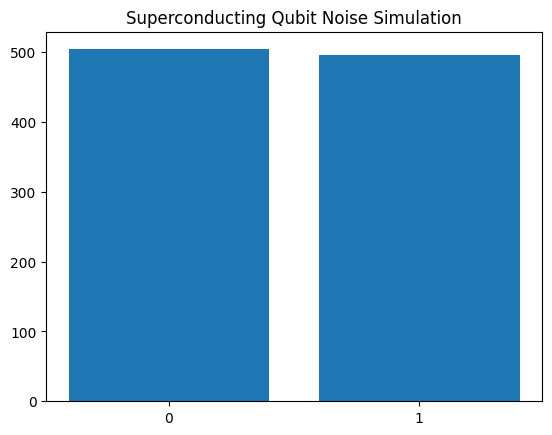

In [8]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import thermal_relaxation_error
import matplotlib.pyplot as plt

T1 = 100e-6
T2 = 80e-6
gate_time = 50e-9
depol_prob = 0.02

noise_model = NoiseModel()
thermal_error = thermal_relaxation_error(T1, T2, gate_time)
depol_error = depolarizing_error(depol_prob, 1)
combined_error = thermal_error.compose(depol_error)
noise_model.add_all_qubit_quantum_error(combined_error, ['x', 'h'])

qc = QuantumCircuit(1, 1)
qc.h(0)
qc.measure(0, 0)

sim = AerSimulator(noise_model=noise_model)
res = sim.run(transpile(qc, sim), shots=1000).result().get_counts()
print(res)
plt.bar(res.keys(), res.values())
plt.title('Superconducting Qubit Noise Simulation')
plt.show()

## 7. DRAG Pulse Design in Qiskit Pulse (|1⟩→|2⟩ leakage suppression)

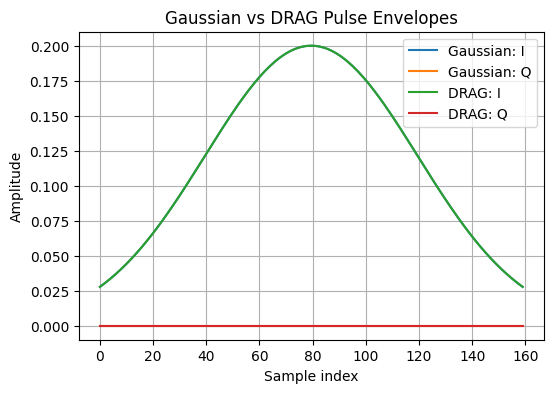

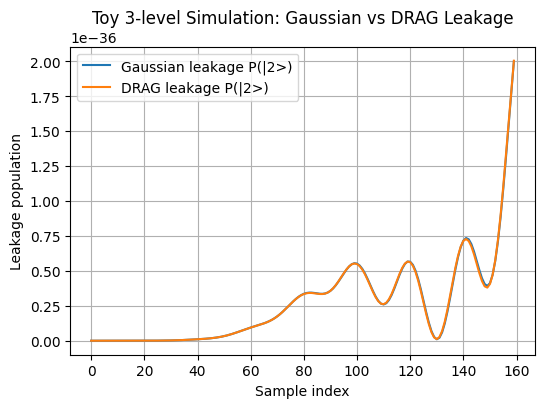

In [9]:
# Qiskit Pulse DRAG example (waveform construction + optional toy simulation)
import numpy as np
import matplotlib.pyplot as plt

# Define Gaussian and DRAG envelope functions manually
def gaussian_env(n, amp, sigma):
    t = np.arange(n); mu = (n-1)/2
    return amp * np.exp(-0.5*((t-mu)/sigma)**2)

def drag_env(n, amp, sigma, beta):
    g = gaussian_env(n, amp, sigma)
    dg = np.gradient(g)
    I = g
    Q = beta * dg
    return I, Q

duration = 160
amp = 0.2
sigma = 40
beta = 0.4

# Generate pulses manually
gI = gaussian_env(duration, amp, sigma)
gQ = np.zeros_like(gI)
dI, dQ = drag_env(duration, amp, sigma, beta)

t = np.arange(duration)

plt.figure(figsize=(6,4))
plt.plot(t, np.real(gI), label='Gaussian: I')
plt.plot(t, np.imag(gQ), label='Gaussian: Q')
plt.plot(t, np.real(dI), label='DRAG: I')
plt.plot(t, np.imag(dQ), label='DRAG: Q')
plt.xlabel('Sample index'); plt.ylabel('Amplitude'); plt.title('Gaussian vs DRAG Pulse Envelopes')
plt.legend(); plt.grid(True); plt.show()

def simulate_three_level(OmegaI, OmegaQ, dt, levels=3):
    N = levels
    alpha = 2*np.pi*200e6
    H0 = np.diag([0.0, 0.0, -alpha])
    a = np.zeros((N,N), dtype=complex)
    for n in range(1,N):
        a[n-1, n] = np.sqrt(n)
    adag = a.conj().T
    psi = np.zeros(N, dtype=complex); psi[0] = 1.0
    P2 = []
    for i in range(len(OmegaI)):
        Ht = H0 + (OmegaI[i]*(a+adag) + OmegaQ[i]*1j*(adag - a))
        psi = psi - 1j * (Ht @ psi) * dt
        psi = psi / np.linalg.norm(psi)
        P2.append(abs(psi[2])**2)
    return np.array(P2)

ns = duration
dt = 0.25e-9

P2g = simulate_three_level(gI, gQ, dt)
P2d = simulate_three_level(dI, dQ, dt)

plt.figure(figsize=(6,4))
plt.plot(P2g, label='Gaussian leakage P(|2>)')
plt.plot(P2d, label='DRAG leakage P(|2>)')
plt.xlabel('Sample index'); plt.ylabel('Leakage population')
plt.title('Toy 3-level Simulation: Gaussian vs DRAG Leakage')
plt.legend(); plt.grid(True); plt.show()

## 8. Open Quantum Systems Simulation (QuTiP, Lindblad, driven transmon)

In [10]:
# If running locally and QuTiP is not installed, uncomment the next line:
# %pip install --user qutip

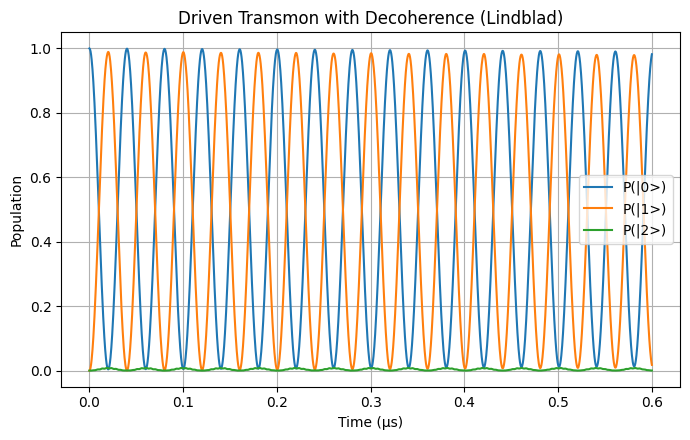

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# QuTiP imports
from qutip import basis, destroy, qeye, mesolve, expect

# ---------- Units & Parameters ----------
# We use MHz for angular frequencies (2π * MHz) and microseconds for time.
# Transmon modeled as a weakly anharmonic oscillator (Kerr oscillator) with 3 levels.
N = 3  # Hilbert space dimension to capture |2> leakage

# Base 0->1 transition frequency (approx.) in MHz (5 GHz)
w01 = 2*np.pi*5000.0

# Anharmonicity (Kerr) in MHz (typical transmon has negative anharmonicity)
alpha = -2*np.pi*200.0  # -200 MHz

# Drive strength in MHz (Rabi rate scale)
Omega = 2*np.pi*25.0  # 25 MHz

# Drive frequency near the 0->1 transition
wd = w01

# Relaxation and dephasing times (microseconds)
T1 = 30.0   # energy relaxation
T2 = 40.0   # total dephasing time
# Pure dephasing Tphi satisfies: 1/T2 = 1/(2*T1) + 1/Tphi
inv_Tphi = max(0.0, (1.0/T2) - (1.0/(2.0*T1)))
Tphi = np.inf if inv_Tphi == 0.0 else 1.0/inv_Tphi

# Time grid (microseconds)
t_final = 0.6  # total evolution time
tlist = np.linspace(0.0, t_final, 2001)

# ---------- Operators ----------
a = destroy(N)
n = a.dag() * a
I = qeye(N)

# Kerr-oscillator transmon Hamiltonian (in lab frame):
# H0 = w01 * n + (alpha/2) * n (n - I)
H0 = w01 * n + (alpha/2.0) * (n * (n - I))

# Drive term H_d = Omega * (a + a^\dagger) * cos(wd * t)
# Use lambda function instead of string to avoid compilation issues
Hd = (a + a.dag())
H = [H0, [Omega * Hd, lambda t, args: np.cos(args['wd'] * t)]]

# ---------- Collapse Operators ----------
c_ops = []
# Energy relaxation (|e> -> |g|). For multilevel, 'a' handles ladder decay.
if np.isfinite(T1) and T1 > 0:
    c_ops.append((1.0/np.sqrt(T1)) * a)

# Pure dephasing via number operator n
if np.isfinite(Tphi) and Tphi > 0:
    c_ops.append((1.0/np.sqrt(Tphi)) * n)

# ---------- Initial State ----------
psi0 = basis(N, 0)  # start in |0>

# ---------- Solve Lindblad Master Equation ----------
args = {"wd": wd}
# Use options dictionary for progress_bar instead of parameter
result = mesolve(H, psi0, tlist, c_ops, e_ops=[], args=args, options={"progress_bar": None})

# ---------- Populations ----------
P0 = expect(basis(N,0) * basis(N,0).dag(), result.states)
P1 = expect(basis(N,1) * basis(N,1).dag(), result.states)
P2 = expect(basis(N,2) * basis(N,2).dag(), result.states)

# ---------- Plot ----------
plt.figure(figsize=(7,4.5))
plt.plot(tlist, P0, label='P(|0>)')
plt.plot(tlist, P1, label='P(|1>)')
plt.plot(tlist, P2, label='P(|2>)')
plt.xlabel('Time (μs)')
plt.ylabel('Population')
plt.title('Driven Transmon with Decoherence (Lindblad)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# --- Quick Tuning Guide ---
# Change Omega (drive strength), alpha (anharmonicity) or decoherence times then re-run the previous cell.
# For example:
# Omega = 2*np.pi*15.0
# alpha = -2*np.pi*240.0
# T1 = 25.0
# T2 = 35.0
# Re-execute the simulation cell to see updated dynamics.
pass